In [43]:
%reload_ext autoreload
%autoreload 2

import time as tt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from utils import get_track

## First, start by defining the paramters

In [2]:
# Flattened NFW halo
logM, Rs, q = 12.0, 25.0, 0.8
dirx, diry, dirz = 1.0, 1.0, 1.0

# Plummer Sattelite
logm, rs = 8.0, 2.0 

# Initial conditions
x0, y0, z0 = 100.0, 0.0, 0.0     # Position in kpc
vx0, vy0, vz0 = 0.0, 200.0, 0.0  # Velocity in km/s

# Integration time
time = 3.0 # Gyr
alpha = 1.05

params = (logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha)

n_steps = 500 # Number of steps in the time integration
n_particles = 10000 # Number of particles in the stream

## (1) Spray Method

In [38]:
from models import generate_stream_spray

start = tt.time()
theta_stream, xv_stream_spray = generate_stream_spray(params,  seed=111, n_steps=n_steps, n_particles=n_particles)
end = tt.time()
print(f"Time taken to generate stream using Spray: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

Time taken to generate stream using Spray: 1.07 seconds


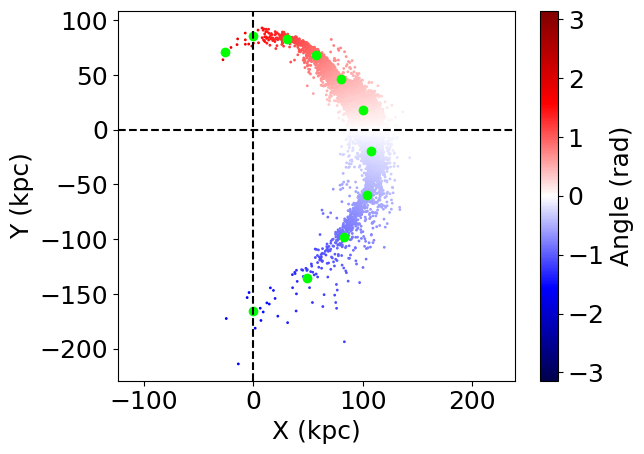

In [142]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (2) Streak Method

In [ ]:
from models import generate_stream_streak

start = tt.time()
theta_stream, xv_stream = generate_stream_streak(params,  seed=111, n_steps=n_steps, n_particles=n_particles)
end = tt.time()
print(f"Time taken to generate stream using Streak: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

Time taken to generate stream using Spray: 0.17 seconds


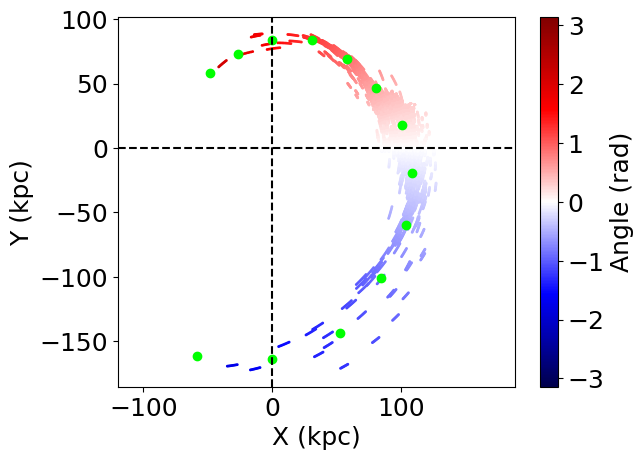

In [44]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (3) Binned method

In [36]:
from models import generate_stream_bin

start = tt.time()
theta_stream, xv_stream, count_stream = generate_stream_bin(params,  seed=111, n_bins=1000, n_steps=n_steps, n_particles=n_particles)

end = tt.time()
print(f"Time taken to generate stream using Streak: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

Time taken to generate stream using Streak: 0.94 seconds


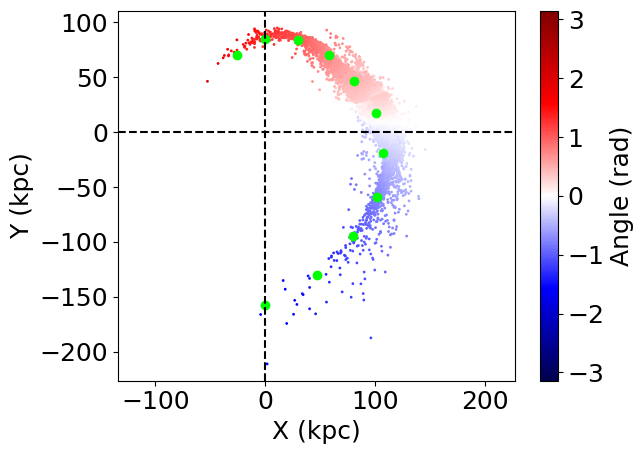

In [39]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=count_stream, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (4) 2nd Degree method

In [48]:
from integrants import integrate_satellite, integrate_stream_spray
import jax
import jax.numpy as jnp
from utils import jax_unwrap, get_rj_vj_R, create_ic_particle_spray
from potentials import NFWHessian

In [50]:
tail = 0
seed = 111

In [ ]:
logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha = params
backward_trajectory = integrate_satellite(x0, y0, z0, vx0, vy0, vz0, logM, Rs, q, dirx, diry, dirz, -time, n_steps)

forward_trajectory  = integrate_satellite(*backward_trajectory[-1, :], logM, Rs, q, dirx, diry, dirz, time*alpha, n_steps)

theta_sat_forward = jnp.arctan2(forward_trajectory[:, 1], forward_trajectory[:, 0])
theta_sat_forward = jnp.where(theta_sat_forward < 0, theta_sat_forward + 2 * jnp.pi, theta_sat_forward)
theta_sat_forward = jax_unwrap(theta_sat_forward)

hessians  = jax.vmap(NFWHessian, in_axes=(0, 0, 0, None, None, None, None, None, None)) \
                    (forward_trajectory[:, 0], forward_trajectory[:, 1], forward_trajectory[:, 2], logM, Rs, q, dirx, diry, dirz)
rj, vj, R = get_rj_vj_R(hessians, forward_trajectory, 10 ** logm)
ic_particle_spray = create_ic_particle_spray(forward_trajectory, rj, vj, R, tail, seed, n_particles, n_steps)

index = jnp.repeat(jnp.arange(0, n_steps, 1), n_particles // n_steps)
theta_stream , theta_stream = jax.vmap(integrate_stream_spray, in_axes=(0, 0, 0, 0, 0, 0, 0, None, None, None, None, None, None, None, None, None, None, None)) \
    (index, ic_particle_spray[:, 0], ic_particle_spray[:, 1], ic_particle_spray[:, 2], ic_particle_spray[:, 3], ic_particle_spray[:, 4], ic_particle_spray[:, 5],
    theta_sat_forward, forward_trajectory, logM, Rs, q, dirx, diry, dirz, logm, rs, time)


In [70]:
ic_particle_spray_1000 = create_ic_particle_spray(forward_trajectory, rj, vj, R, tail, seed, 1000, n_steps)
ic_particle_spray_10000 = create_ic_particle_spray(forward_trajectory, rj, vj, R, tail, seed, 10000, n_steps)


In [69]:
ic_particle_spray_10000[:, 0] == ic_particle_spray_1000[:,0][0]

Array([False, False, False, ..., False, False, False], dtype=bool)

In [71]:
from potentials import NFWHessian

In [74]:
NFWHessian(1. , 1. , 1. , logM, Rs, q, dirx, diry, dirz)

Array([[1239.93289958, -517.45553756, -909.01329459],
       [-517.45553756, 1239.93289958, -909.01329459],
       [-909.01329459, -909.01329459, 1690.39673944]], dtype=float64)

In [93]:
from potentials import NFWAcceleration, PlummerAcceleration, PlummerHessian
from constants import KPC_TO_KM, GYR_TO_S

def leapfrog_first_combined_step(state, dt, logM, Rs, q, dirx, diry, dirz, logm, rs):
    """
    Leapfrog integration step for both satellite and stream motion for NFW and Plummer potentials.
    """
    (x, y, z, vx, vy, vz, xp, yp, zp, vxp, vyp, vzp), xS, vS = state

    # Update Satellite Position
    axp, ayp, azp = NFWAcceleration(xp, yp, zp, logM, Rs, q, dirx, diry, dirz)

    vxp_half = vxp + 0.5 * dt * axp * KPC_TO_KM**-1
    vyp_half = vyp + 0.5 * dt * ayp * KPC_TO_KM**-1
    vzp_half = vzp + 0.5 * dt * azp * KPC_TO_KM**-1

    xp_new = xp + dt * vxp_half * GYR_TO_S * KPC_TO_KM**-1
    yp_new = yp + dt * vyp_half * GYR_TO_S * KPC_TO_KM**-1
    zp_new = zp + dt * vzp_half * GYR_TO_S * KPC_TO_KM**-1

    axp_new, ayp_new, azp_new = NFWAcceleration(xp_new, yp_new, zp_new, logM, Rs, q, dirx, diry, dirz)

    vxp_new = vxp_half + 0.5 * dt * axp_new * KPC_TO_KM**-1
    vyp_new = vyp_half + 0.5 * dt * ayp_new * KPC_TO_KM**-1
    vzp_new = vzp_half + 0.5 * dt * azp_new * KPC_TO_KM**-1

    # Update Stream Position
    ax, ay, az = NFWAcceleration(x, y, z, logM, Rs, q, dirx, diry, dirz) +  \
                    PlummerAcceleration(x, y, z, logm, rs, x_origin=xp, y_origin=yp, z_origin=zp) # km2 / s / Gyr / kpc

    vx_half = vx + 0.5 * dt * ax * KPC_TO_KM**-1 # km / s
    vy_half = vy + 0.5 * dt * ay * KPC_TO_KM**-1
    vz_half = vz + 0.5 * dt * az * KPC_TO_KM**-1

    x_new = x + dt * vx_half * GYR_TO_S * KPC_TO_KM**-1 # kpc
    y_new = y + dt * vy_half * GYR_TO_S * KPC_TO_KM**-1
    z_new = z + dt * vz_half * GYR_TO_S * KPC_TO_KM**-1

    ax_new, ay_new, az_new = NFWAcceleration(x_new, y_new, z_new, logM, Rs, q, dirx, diry, dirz) +  \
                                PlummerAcceleration(x_new, y_new, z_new, logm, rs, x_origin=xp_new, y_origin=yp_new, z_origin=zp_new) # km2 / s / Gyr / kpc

    vx_new = vx_half + 0.5 * dt * ax_new * KPC_TO_KM**-1 # km / s
    vy_new = vy_half + 0.5 * dt * ay_new * KPC_TO_KM**-1
    vz_new = vz_half + 0.5 * dt * az_new * KPC_TO_KM**-1

    # Update first degree
    Hess = NFWHessian(x, y, z, logM, Rs, q, dirx, diry, dirz) +  \
                    PlummerHessian(x, y, z, logm, rs, x_origin=xp, y_origin=yp, z_origin=zp) # km2 / s / Gyr / kpc
    Z3 = jnp.zeros((3, 3))
    I3 = jnp.identity(3)
    A = jnp.block([
        [Z3,  I3     ],
        [-Hess,  Z3     ]
    ])

    aS = A @ xS
    vS_half = vS + 0.5 * dt * aS * KPC_TO_KM**-1  # km / s
    xS_new = xS + dt * vS_half * GYR_TO_S * KPC_TO_KM**-1  # kpc

    aS_new = A @ xS_new
    vS_new = vS_half + 0.5 * dt * aS_new * KPC_TO_KM**-1  # km / s

    return (x_new, y_new, z_new, vx_new, vy_new, vz_new, xp_new, yp_new, zp_new, vxp_new, vyp_new, vzp_new), xS_new, vS_new

In [94]:
true_state0 = jnp.concatenate([ic_particle_spray_1000[0], forward_trajectory[0]])
state0 = ((true_state0), jnp.identity(6), jnp.zeros([6,6]))

In [95]:
state1 = leapfrog_first_combined_step(state0, 0.01, logM, Rs, q, dirx, diry, dirz, logm, rs)

In [96]:
state1

((Array(50.94286107, dtype=float64),
  Array(113.58599978, dtype=float64),
  Array(1.5583365, dtype=float64),
  Array(-135.92644275, dtype=float64),
  Array(29.04029218, dtype=float64),
  Array(-81.87598634, dtype=float64),
  Array(46.00934897, dtype=float64),
  Array(97.51368705, dtype=float64),
  Array(-2.491444, dtype=float64),
  Array(-144.94558183, dtype=float64),
  Array(32.72448424, dtype=float64),
  Array(-93.25126655, dtype=float64)),
 Array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.65719220e-21,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.65719220e-21,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.65719220e-21],
        [-1.16047320e-21,  3.04989782e-21, -1.67109116e-22,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.04989782e-21,  3.12323129e-21, -6.00803738e-22,
        